Hallo, Kak Reviewer. 

Perkenalkan, namaku Muhammad Imron, bisa dipanggil Imron. Di submission NLP ini, aku pakai dataset dari UCI Machine Learning, kak, namanya News_Final.csv. Rencananya di submission ini aku bakalan nerapin multiclass text classification tentang nyari tipe berita berdasarkan headlinenya.

Mohon bantuannya kak, untuk direview.

Terima kasih

---

https://archive.ics.uci.edu/ml/datasets/News+Popularity+in+Multiple+Social+Media+Platforms#

In [19]:
# Import library yang dibutuhkan
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import os

from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [20]:
# Import dataset
df = pd.read_csv('/content/drive/MyDrive/NLP_Submission/News_Final.csv')
df.tail()

,IDLink,Title,Headline,Source,Topic,PublishDate,SentimentTitle,SentimentHeadline,Facebook,GooglePlus,LinkedIn
93234,61851.0,Stocks rise as investors key in on US economy ...,The June employment report is viewed as a cruc...,MarketWatch,economy,2016-07-07 15:31:05,0.104284,0.044943,-1,3,5
93235,61865.0,Russian PM proposes to use conservative and to...,"In addition, establish stimulating economic po...",TASS,economy,2016-07-07 15:31:10,0.072194,0.000000,-1,0,1
93236,104793.0,Palestinian Government Uses Foreign Aid To Pay...,The Palestinian government spends nearly $140 ...,Daily Caller,palestine,2016-07-07 15:38:26,0.291667,-0.139754,5,1,0
93237,104794.0,Palestine Youth Orchestra prepares for first U...,Palestine Youth Orchestra prepares for first U...,Ahram Online,palestine,2016-07-07 15:59:22,0.121534,0.092313,0,0,0
93238,61870.0,Sausalito businesswoman wins $10000 in Microso...,"Goldstein, the proprietor of the TG Travel Gro...",East Bay Times,microsoft,2016-07-07 16:16:11,0.000000,0.054554,-1,1,0


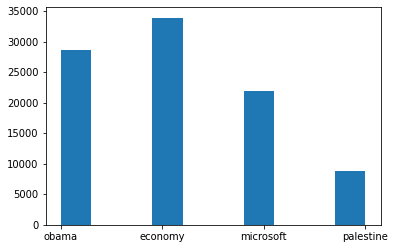

In [21]:
plt.hist(df['Topic'])
plt.show()

In [22]:
# One Hot Encoding
category = pd.get_dummies(df.Topic)
new_df = pd.concat([df, category], axis=1)
new_df = new_df.sample(frac=1).reset_index()
new_df = new_df.drop(columns=['index', 'IDLink', 'Topic', 'Title', 
                              'Source', 'PublishDate', 'SentimentTitle', 
                              'SentimentHeadline', 'Facebook', 
                              'GooglePlus', 'LinkedIn'])
new_df.Headline = new_df.Headline.astype(str)
new_df

,Headline,economy,microsoft,obama,palestine
0,"WHITEY Basson, CEO of Africa's largest grocer,...",1,0,0,0
1,Britain's exit from the EU after June's refere...,1,0,0,0
2,"FRANKFURT, Germany (AP) — The head of the Inte...",1,0,0,0
3,Indian economy to grow 7.7% in 2016-17: ICRA. ...,1,0,0,0
4,A recent interview given by President Barack O...,0,0,1,0
...,...,...,...,...,...
93234,I think the votes [to block funding for Obama'...,0,0,1,0
93235,Palestine girls soccer player Karina Trejo dri...,0,0,0,1
93236,Microsoft is to retire its Microsoft Virtual M...,0,1,0,0
93237,Obama Administration targets funds for communi...,0,0,1,0


In [24]:
# Train Test Splitting
sentence = new_df['Headline'].values
label = new_df[['economy', 'microsoft', 'obama', 'palestine']].values
sentence_train, sentence_test, label_train, label_test = train_test_split(sentence, label, test_size=0.2)

In [26]:
# Tokenization dan Sequencing
tokenizer = Tokenizer(num_words=10000, oov_token='x')
tokenizer.fit_on_texts(sentence_train)
tokenizer.fit_on_texts(sentence_test)

sekuens_train = tokenizer.texts_to_sequences(sentence_train)
sekuens_test = tokenizer.texts_to_sequences(sentence_test)

padded_train = pad_sequences(sekuens_train)
padded_test = pad_sequences(sekuens_test)

In [31]:
# Membangun arsitektur model dan compile model
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=10000, output_dim=1000),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.15),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(4, activation='softmax')
])
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [32]:
# Sebelum melakukan fitting, saya coba menambahkan callbacks untuk checkpoint dan earlystopping
models_dir = 'save_models'
if not os.path.exists(models_dir):
  os.makedirs(models_dir)

# Checkpointer
checkpointer = ModelCheckpoint(filepath=os.path.join(models_dir, 'model.hdf5'),
                               monitor='val_accuracy', mode='max',
                               verbose=1, save_best_only=True)

# Reduce Learning Rate
reduce_learning_rate = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=1, min_lr=0.0001)

# EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', mode='min',
                               verbose=1, patience=3)

# Membuat callback
callbacks = [early_stopping, checkpointer, reduce_learning_rate]

In [33]:
# Fitting model
num_epochs = 30
history = model.fit(padded_train, 
                    label_train, 
                    epochs=num_epochs,
                    validation_data=(padded_test, label_test),
                    callbacks=callbacks)

Epoch 1/30
2328/2331 [============================>.] - ETA: 0s - loss: 0.1299 - accuracy: 0.9547
Epoch 1: val_accuracy improved from -inf to 0.96976, saving model to save_models/model.hdf5
2331/2331 [==============================] - 34s 14ms/step - loss: 0.1298 - accuracy: 0.9547 - val_loss: 0.0855 - val_accuracy: 0.9698 - lr: 0.0010
Epoch 2/30
2331/2331 [==============================] - ETA: 0s - loss: 0.0556 - accuracy: 0.9822
Epoch 2: val_accuracy improved from 0.96976 to 0.97367, saving model to save_models/model.hdf5
2331/2331 [==============================] - 33s 14ms/step - loss: 0.0556 - accuracy: 0.9822 - val_loss: 0.0845 - val_accuracy: 0.9737 - lr: 0.0010
Epoch 3/30
2329/2331 [============================>.] - ETA: 0s - loss: 0.0320 - accuracy: 0.9900
Epoch 3: val_accuracy did not improve from 0.97367
2331/2331 [==============================] - 33s 14ms/step - loss: 0.0320 - accuracy: 0.9900 - val_loss: 0.0969 - val_accuracy: 0.9720 - lr: 0.0010
Epoch 4/30
2330/2331 [==

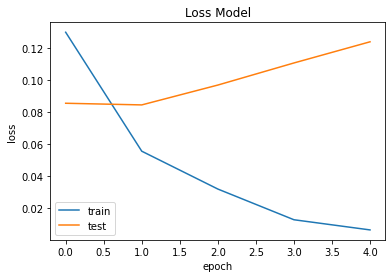

In [39]:
# Plot Loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss Model')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower left')
plt.show()

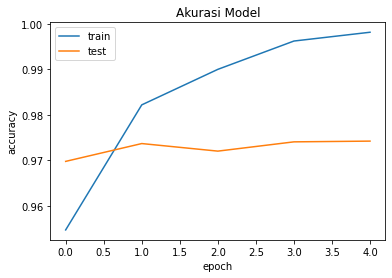

In [35]:
# Plot Akurasi
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Akurasi Model')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()